In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Save Kyoto_Gases data (2020-2100), consider the case of C1-C8 for simplicity.
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')
X_Emissions = Kyoto_Gases
X_Emissions = X_Emissions[X_Emissions['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
X_Emissions.reset_index(drop=True,inplace=True)
mapping = {'C1':1,'C2':2,'C3':3,'C4':4,'C5':5,'C6':6,'C7':7,'C8':8}
X_Emissions['Category'].replace(mapping,inplace=True)
X_Emissions.drop(columns=['Category_name'],inplace=True)

C:\Users\l1137\AppData\Local\Temp\ipykernel_65896\3013020388.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Emissions['Category'].replace(mapping,inplace=True)
C:\Users\l1137\AppData\Local\Temp\ipykernel_65896\3013020388.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Emissions.drop(columns=['Category_name'],inplace=True)


In [3]:
#Merge models according to a uniform standard
MESSAGEix = list(set([i for i in X_Emissions['Model'] if  'MESSAGE' in i]))
WITCH = list(set([i for i in X_Emissions['Model'] if  'WITCH' in i]))
COFFEE = ['COFFEE 1.1']
REMIND = list(set([i for i in X_Emissions['Model'] if  'REM' in i]))
TIA = list(set([i for i in X_Emissions['Model'] if  'TIAM-ECN' in i]))
POL = list(set([i for i in X_Emissions['Model'] if  'POL' in i]))
AIM = list(set([i for i in X_Emissions['Model'] if  'AIM' in i]))
IMA = list(set([i for i in X_Emissions['Model'] if  'IMAGE' in i]))
GCA = list(set([i for i in X_Emissions['Model'] if  'GCA' in i]))

In [4]:
Model = [MESSAGEix,WITCH,COFFEE,REMIND,TIA,POL,AIM,IMA,GCA]
Model_names = ['MESSAGEix','WITCH','COFFEE','REMIND','TIA','POL','AIM','IMA','GCA']
Model_List = []
for i in Model:
    Model_List += i

In [5]:
X_Emissions = X_Emissions[X_Emissions['Model'].isin(Model_List)]

In [6]:
mapping = {j:Model_names[i] for i in range(len(Model)) for j in Model[i]}
X_Emissions['Model'].replace(mapping,inplace=True)
X_Emissions.reset_index(drop=True,inplace=True)

In [7]:
#Load a dataset of individual variables
CarbonSequestration = pd.read_csv('Carbon_Sequestration_CCS_imputed.csv')
FinalEnergy_Gase = pd.read_csv('Final Energy_Gases.csv')
FinalEnergy_Liquid = pd.read_csv('Final Energy_Liquids.csv')
FinalEnergy_Solid = pd.read_csv('Final Energy_Solids.csv')
FinalEnergy = pd.read_csv('Final_Energy_ts_imputed.csv')
PrimaryEnergy_Gas = pd.read_csv('Primary Energy_Gas.csv')
PrimaryEnergy_Oil = pd.read_csv('Primary Energy_Oil.csv')
PrimaryEnergy_Solar = pd.read_csv('Primary Energy_Solar.csv')
PrimaryEnergy_Coal = pd.read_csv('PrimaryEnergy_Coal.csv')
PrimaryEnergy = pd.read_csv('PrimaryEnergy_imputed.csv')
SecondaryEnergy_Gas = pd.read_csv('Secondary Energy_Gases.csv')
SecondaryEnergy_Liquid = pd.read_csv('Secondary Energy_Liquids.csv')
SecondaryEnergy_Electricity = pd.read_csv('SecondaryEnergyElectricity_imputed.csv')

In [8]:
##Get the intersection of the models and scenarios contained in each variable
baseline = X_Emissions[['Model','Scenario']]
Variables = [CarbonSequestration,FinalEnergy,FinalEnergy_Gase,FinalEnergy_Liquid,FinalEnergy_Solid,PrimaryEnergy,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil,PrimaryEnergy_Solar,SecondaryEnergy_Electricity,SecondaryEnergy_Gas,SecondaryEnergy_Liquid]
for i in range(len(Variables)):
    Variables[i]['Model'].replace(mapping,inplace=True)
for variable in Variables:
    baseline = pd.merge(baseline,variable[['Model','Scenario']],on=['Model','Scenario'],how='inner')

In [9]:
for i in range(len(Variables)):
     Variables[i] = pd.merge(baseline,Variables[i],on=['Model','Scenario'],how='inner')

In [10]:
Features1 = np.zeros((996,13))#Feature_Sum:13 Features Accumulation from 2010 to 2100
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        for k in range(9):
            Features1[i][j] += (X[i][k] + X[i][k+1]) * 5
Features2 = np.zeros((996,13))#Feature_2010_2050:13 Features Rate of change 2010-2050
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        Features2[i][j] = (X[i][4] - X[i][0]) / 40 
Features3 = np.zeros((996,13))#Feature_2050_2100:13 Features Rate of change 2050-2100
for i in range(996):
    for j in range(len(Variables)):
        X = Variables[j].iloc[:,2:-2].values
        Features3[i][j] = (X[i][9] - X[i][4]) / 50
Features = np.concatenate((Features1,Features2,Features3),axis=1)

In [11]:
X_Emissions = pd.merge(X_Emissions,baseline,on = ['Model','Scenario'],how = 'inner')

In [12]:
columns_names1 = ['CarbonSequestration','FinalEnergy','FinalEnergy_Gase','FinalEnergy_Liquid','FinalEnergy_Solid','PrimaryEnergy','PrimaryEnergy_Coal','PrimaryEnergy_Gas','PrimaryEnergy_Oil','PrimaryEnergy_Solar','SecondaryEnergy_Electricity','SecondaryEnergy_Gas','SecondaryEnergy_Liquid']
columns_names2 = [feature + '2010-2050' for feature in columns_names1]
columns_names3 = [feature + '2050-2100' for feature in columns_names1]
columns_names = columns_names1 + columns_names2 + columns_names3
DataSet = pd.DataFrame(Features,columns = columns_names)
DataSet['Category'] = X_Emissions['Category']

In [13]:
DataSet

,CarbonSequestration,FinalEnergy,FinalEnergy_Gase,FinalEnergy_Liquid,FinalEnergy_Solid,PrimaryEnergy,PrimaryEnergy_Coal,PrimaryEnergy_Gas,PrimaryEnergy_Oil,PrimaryEnergy_Solar,...,FinalEnergy_Solid2050-2100,PrimaryEnergy2050-2100,PrimaryEnergy_Coal2050-2100,PrimaryEnergy_Gas2050-2100,PrimaryEnergy_Oil2050-2100,PrimaryEnergy_Solar2050-2100,SecondaryEnergy_Electricity2050-2100,SecondaryEnergy_Gas2050-2100,SecondaryEnergy_Liquid2050-2100,Category
0,4.508393e+05,32688.874000,2555.739000,10200.140000,2576.368500,43908.707500,6098.367000,7503.115000,11754.266000,3332.629000,...,-0.353030,-1.084484,-0.571912,-0.144834,-1.595626,0.504446,1.085166,-0.446842,-1.287788,3
1,1.563286e+05,34638.369500,3379.300000,11891.932500,2687.750000,47370.059500,8196.062500,8760.724500,13901.899500,2490.145000,...,-0.386568,-1.149094,-0.842294,-0.362446,-1.536646,0.404362,1.071156,-0.498274,-1.295358,5
2,2.055490e+02,36222.393500,3903.056500,12788.197000,2814.974000,50518.034500,10796.385000,10060.634000,15114.422500,2068.330000,...,-0.448598,-2.003146,-1.740870,-0.225150,-1.419940,0.361252,0.864040,-0.517180,-1.198014,6
3,1.049622e+06,41601.854500,2887.082500,10571.457000,7102.864000,58162.302000,10677.938000,8840.295000,12670.412000,3223.048500,...,0.497644,0.913272,-0.698346,-0.348038,-1.849530,0.550612,2.600658,-0.568404,-1.610612,3
4,5.515162e+05,43293.412500,3671.316000,11816.288500,7279.973000,60377.297000,12032.100000,9505.322000,14110.779500,2692.969500,...,0.456358,1.408292,-0.531364,-0.395160,-1.637438,0.417282,2.523594,-0.521700,-1.456094,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1.048893e+01,46134.259092,8041.812453,16717.466764,4739.547218,85221.226631,20397.835008,21256.243137,28689.705003,1366.403842,...,-0.543473,6.523957,0.369325,1.551081,1.052544,0.714452,3.586431,1.033042,1.508336,7
992,6.860652e+05,32784.650333,3079.557238,10181.034105,4330.209288,54630.308157,5650.644265,7558.605127,11333.047985,3700.744001,...,-0.344229,5.429979,-0.193083,-0.024971,-1.826536,1.422893,5.242380,-0.318115,-0.102225,1
993,7.051782e+05,35389.375587,3997.153295,12127.803729,4388.466750,59954.700740,6122.377155,9944.400041,16683.037371,3295.806341,...,-0.372083,5.091108,-0.241906,-0.034624,-2.545616,1.365017,4.979441,-0.361625,0.351478,3
994,7.901026e+05,30438.812642,2202.385120,7997.701183,4362.752366,51387.401955,5380.945420,5354.457611,7012.531855,4001.532830,...,-0.363265,5.794348,-0.082133,-0.056977,-0.427819,1.420321,5.353506,-0.241305,-0.448014,1


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = DataSet.drop(columns='Category')
y = DataSet['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Create random forest classifier object
rf_classifier = RandomForestClassifier(n_estimators=3000,max_depth=14,random_state=5)

#Fitting Model
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Classification accuracy on training datasets:", accuracy)

Classification accuracy on training datasets: 0.9974874371859297


In [15]:
# Prediction on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Classification accuracy on test datasets:", accuracy)

Classification accuracy on test datasets: 0.87


In [16]:
#Importance of Feature
importance = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df)
#The importance score of each feature is ranked from largest to smallest

                                 Feature  Importance
6                     PrimaryEnergy_Coal    0.068588
13          CarbonSequestration2010-2050    0.066665
19           PrimaryEnergy_Coal2010-2050    0.055783
0                    CarbonSequestration    0.054326
8                      PrimaryEnergy_Oil    0.041961
21            PrimaryEnergy_Oil2010-2050    0.037613
18                PrimaryEnergy2010-2050    0.036810
16           FinalEnergy_Liquid2010-2050    0.034836
7                      PrimaryEnergy_Gas    0.033565
24          SecondaryEnergy_Gas2010-2050    0.030307
3                     FinalEnergy_Liquid    0.029503
5                          PrimaryEnergy    0.029234
26          CarbonSequestration2050-2100    0.028871
20            PrimaryEnergy_Gas2010-2050    0.026940
15             FinalEnergy_Gase2010-2050    0.022344
11                   SecondaryEnergy_Gas    0.021918
23  SecondaryEnergy_Electricity2010-2050    0.021802
4                      FinalEnergy_Solid    0.

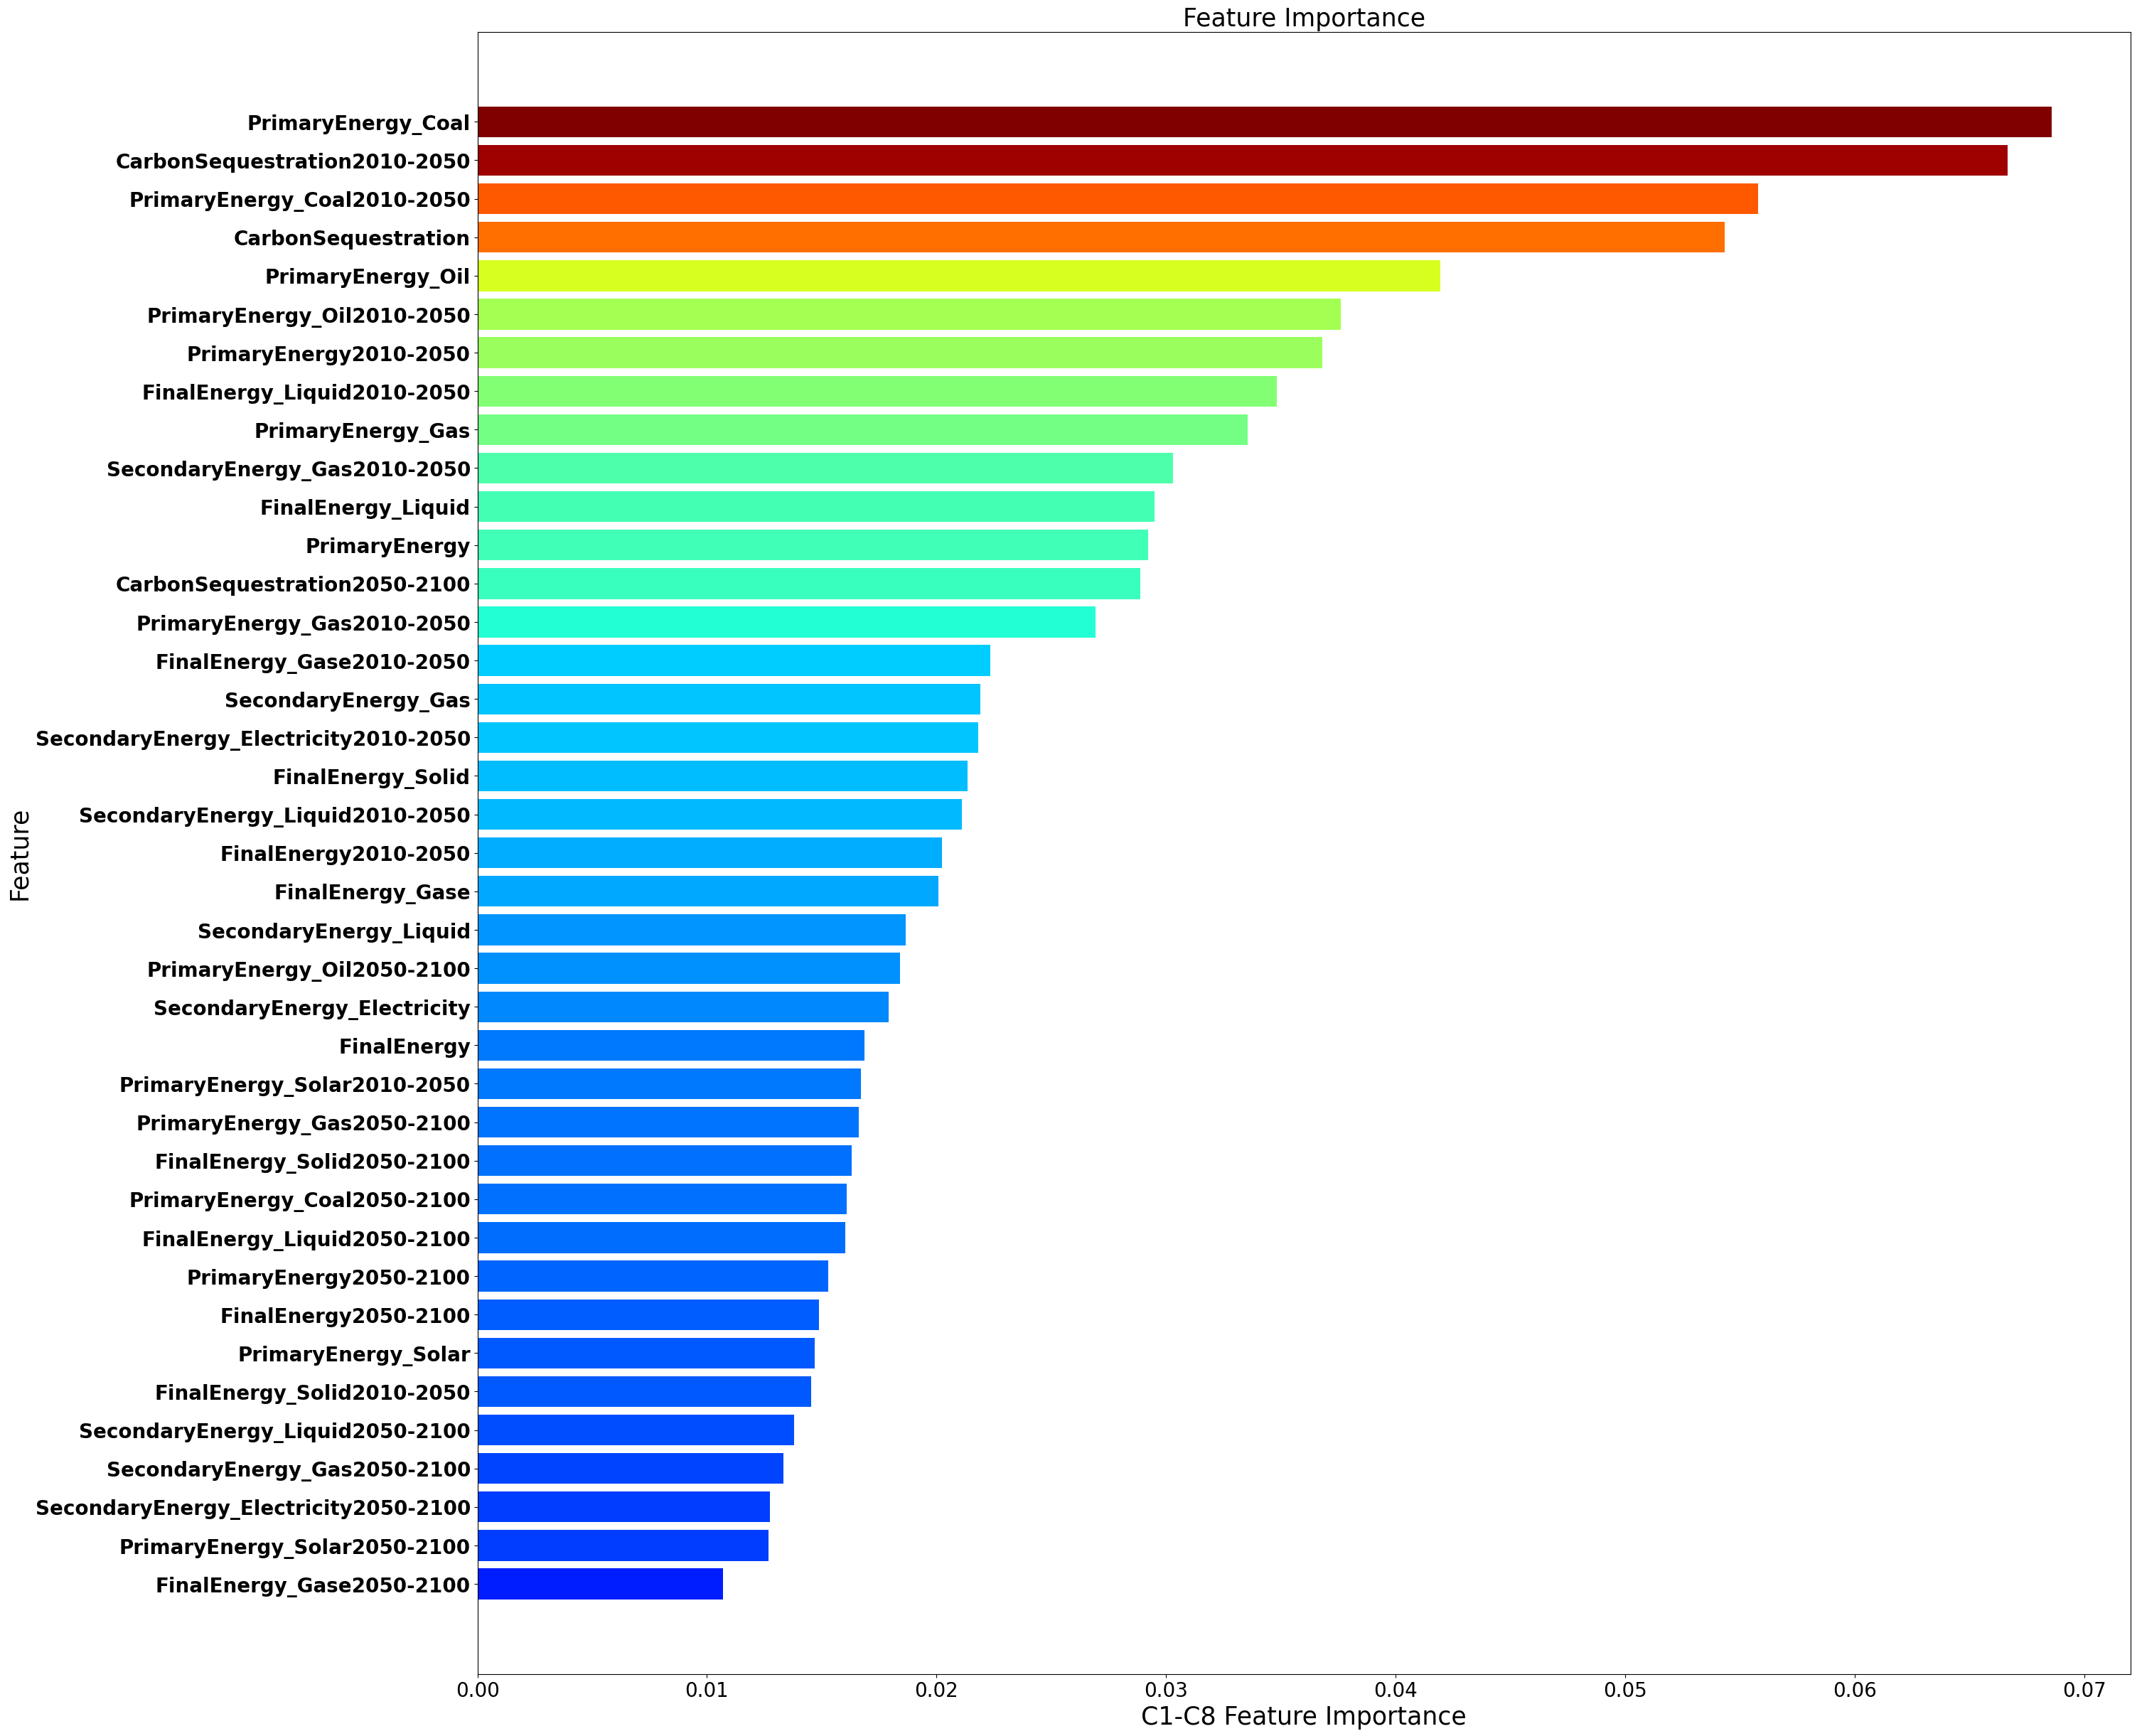

In [17]:
plt.figure(figsize=(30, 30))
sorted_df = feature_importance_df.sort_values(by='Importance', ascending=True)
colors = plt.cm.jet(sorted_df['Importance'] / np.max(sorted_df['Importance']))
plt.barh(sorted_df['Feature'], sorted_df['Importance'],color = colors)
plt.xlabel('C1-C8 Feature Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)
plt.title('Feature Importance',fontsize=25)
plt.yticks(fontsize=20,weight='bold')
plt.xticks(fontsize=20)
#plt.savefig('C1-C8-Category-2010-2050-2100 + Accmulation.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [18]:
#Aggregate the categories and then train the random forest model
mapping = {1:1,2:1,3:1,4:2,5:2,6:2,7:3,8:3}
DataSet['Category'].replace(mapping,inplace=True)

In [19]:
X = DataSet.drop(columns='Category')
y = DataSet['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

#Create random forest classifier object
rf_classifier2 = RandomForestClassifier(n_estimators=1000,max_depth=8,random_state=5)

# Fitting Model
rf_classifier2.fit(X_train, y_train)
y_pred = rf_classifier2.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Classification accuracy on training datasets:", accuracy)

Classification accuracy on training datasets: 0.9987437185929648


In [20]:
# Predict on test data
y_pred = rf_classifier2.predict(X_test)

# Calculate classification accuracy
accuracy = accuracy_score(y_test, y_pred)
print("classification accuracy:", accuracy)

classification accuracy: 0.965


In [21]:
#Feature Importance
importance = rf_classifier2.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print(feature_importance_df)
#The importance score of each feature is ranked from largest to smallest

                                 Feature  Importance
13          CarbonSequestration2010-2050    0.101296
6                     PrimaryEnergy_Coal    0.091958
19           PrimaryEnergy_Coal2010-2050    0.074819
8                      PrimaryEnergy_Oil    0.059003
0                    CarbonSequestration    0.058869
21            PrimaryEnergy_Oil2010-2050    0.050222
24          SecondaryEnergy_Gas2010-2050    0.045850
16           FinalEnergy_Liquid2010-2050    0.042989
18                PrimaryEnergy2010-2050    0.039511
20            PrimaryEnergy_Gas2010-2050    0.038845
7                      PrimaryEnergy_Gas    0.034099
3                     FinalEnergy_Liquid    0.027926
23  SecondaryEnergy_Electricity2010-2050    0.027690
15             FinalEnergy_Gase2010-2050    0.025198
5                          PrimaryEnergy    0.025043
26          CarbonSequestration2050-2100    0.024281
4                      FinalEnergy_Solid    0.018135
14                  FinalEnergy2010-2050    0.

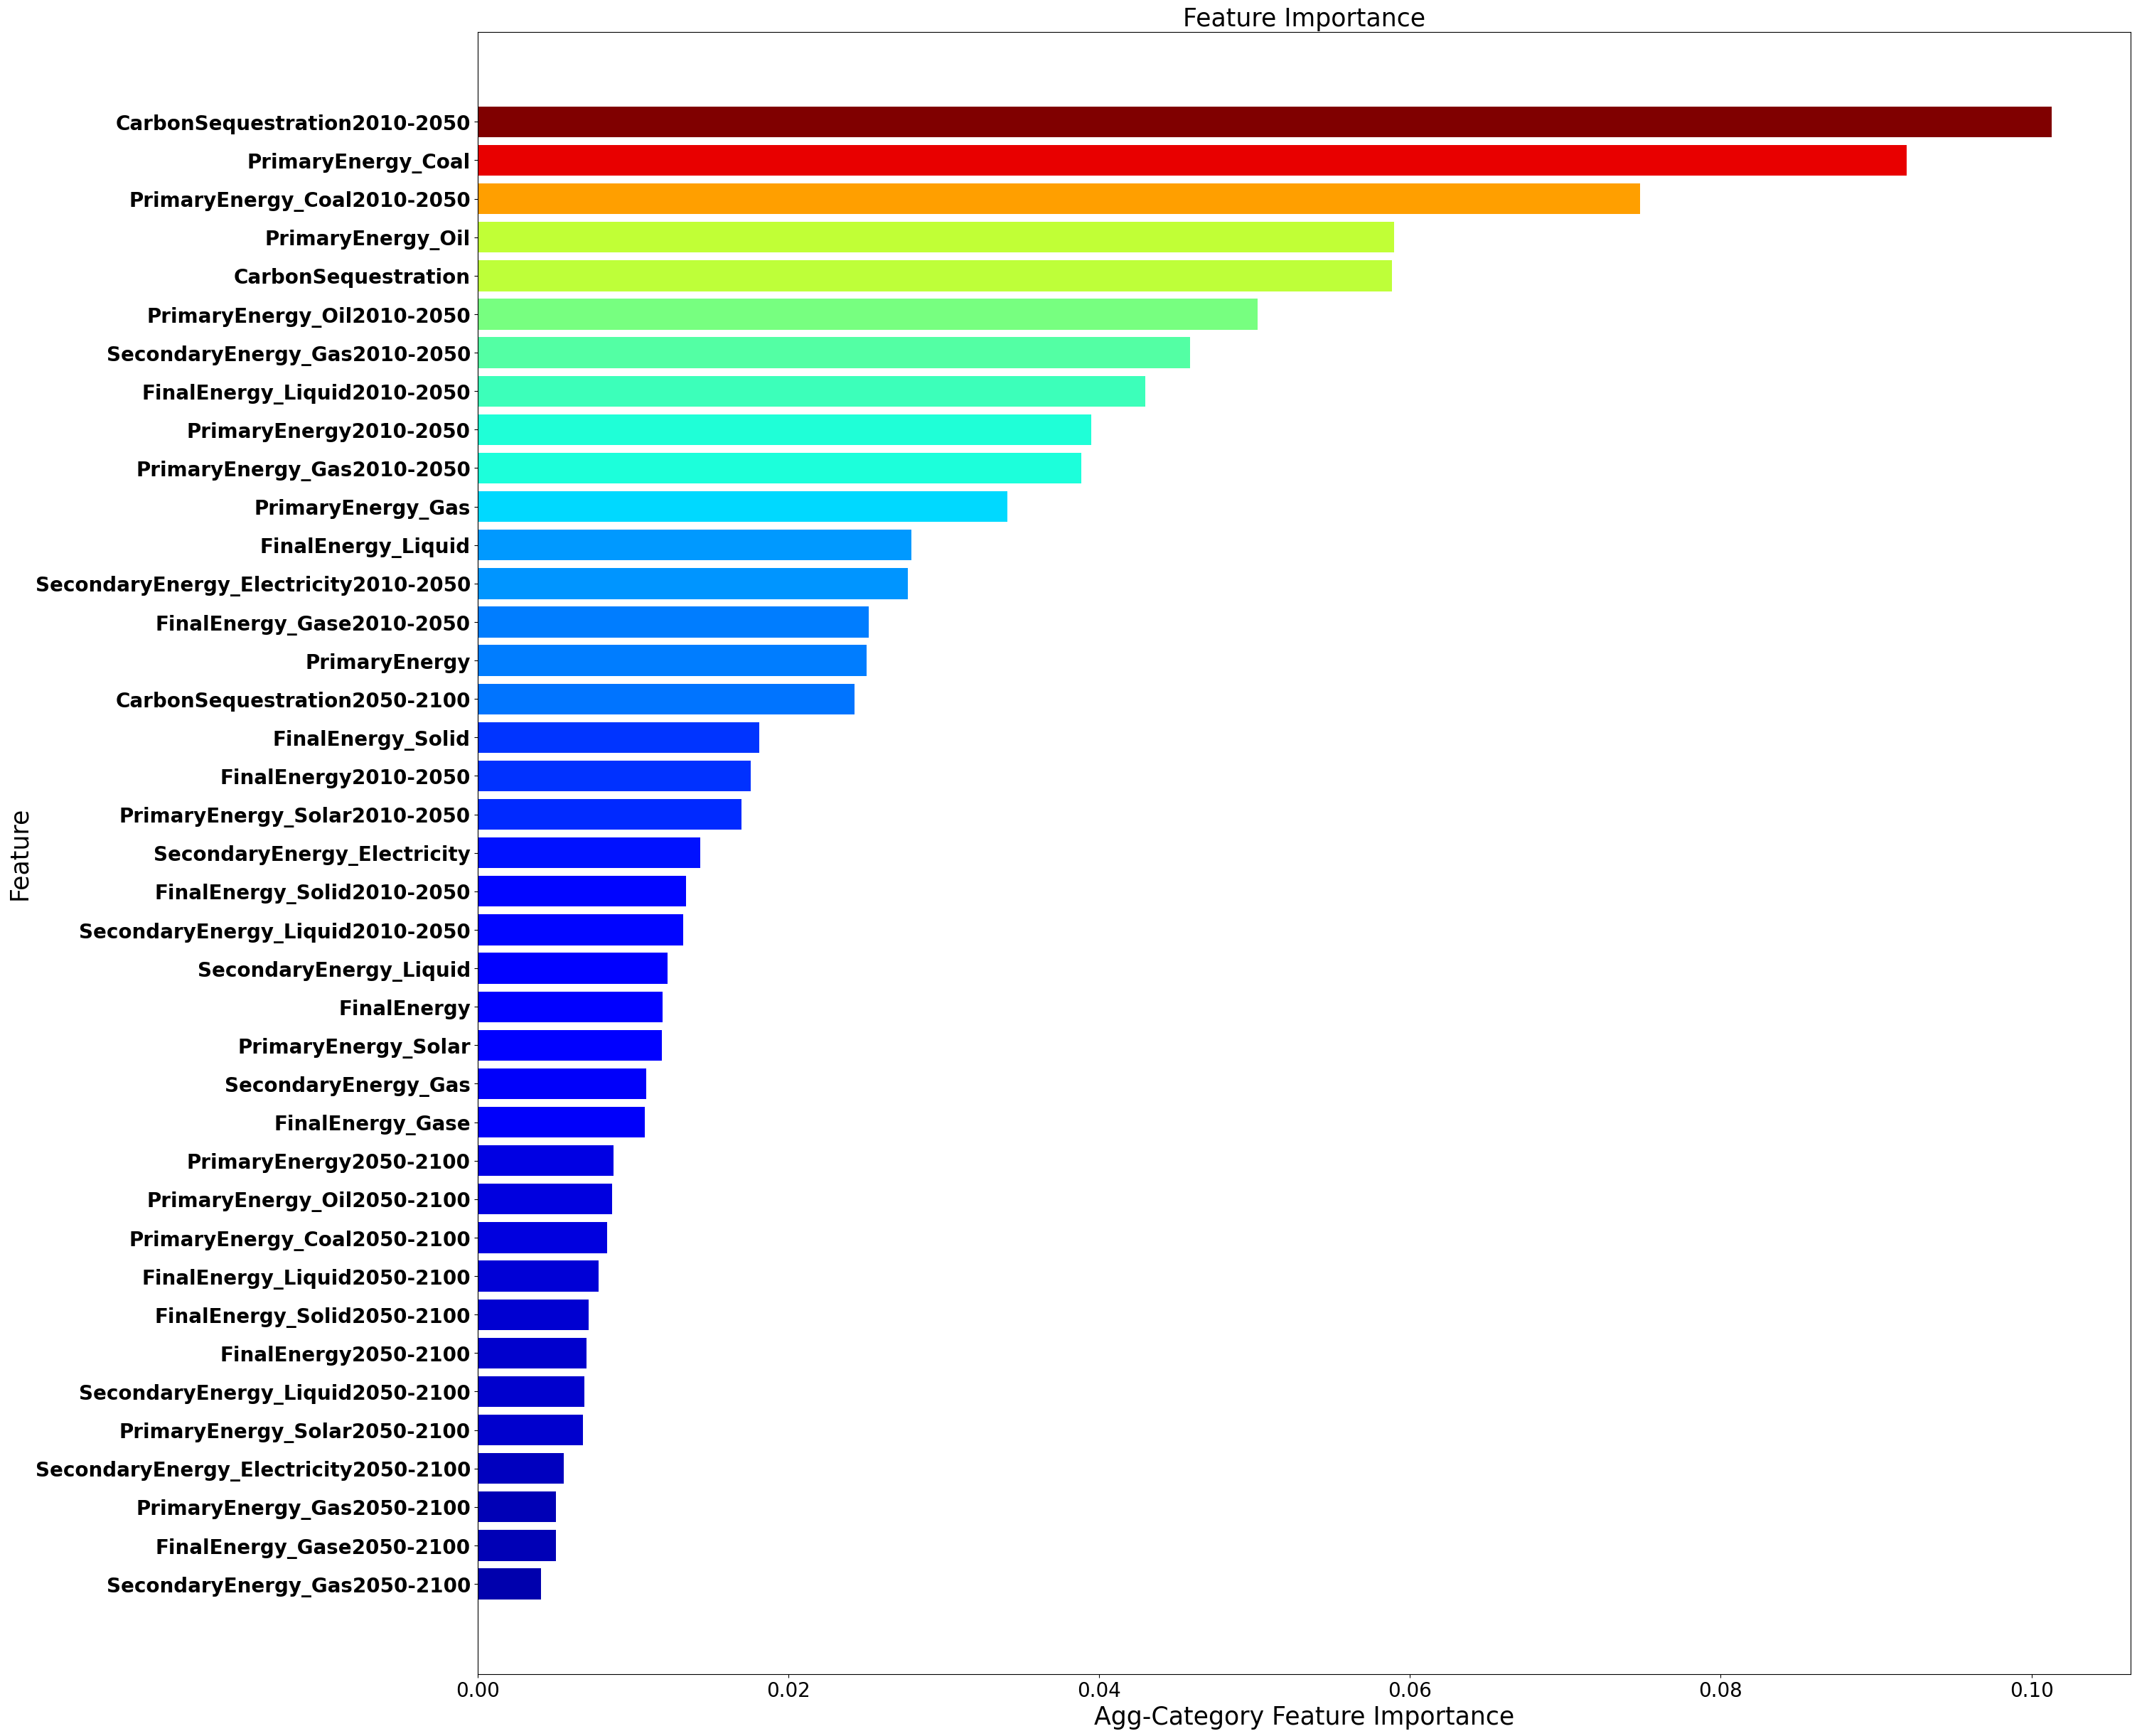

In [22]:
plt.figure(figsize=(30, 30))
sorted_df = feature_importance_df.sort_values(by='Importance', ascending=True)
colors = plt.cm.jet(sorted_df['Importance'] / np.max(sorted_df['Importance']))
plt.barh(sorted_df['Feature'], sorted_df['Importance'],color = colors)
plt.xlabel('Agg-Category Feature Importance',fontsize=25)
plt.ylabel('Feature',fontsize=25)
plt.title('Feature Importance',fontsize=25)
plt.yticks(fontsize=20,weight='bold')
plt.xticks(fontsize=20)
#plt.savefig('AggCategory-2010-2050-2100 + Accmulation.pdf',format='pdf',bbox_inches='tight')
plt.show()